# CNN Multi Class Image Classification

### Components of CNN

- Input Layer
- Convolutional Layer
- Activation Function
- Pooling Layer
- Fully Connected Layer (Dense Layer)
- Output Layer
- Loss Function
- Optimizer

# Directory Structure Of Images

```bash
data/images/
│
├── car/
│   ├── car_1.jpg, car_2.jpg, ..., car_20.jpg
│
├── person/
│   ├── person_1.jpg, person_2.jpg, ..., person_20.jpg
│
└── dog/
    ├── dog_1.jpg, dog_2.jpg, ..., dog_20.jpg

```

In [1]:
import os

print(os.getcwd())

c:\Users\Akhil\Python_Projects\CNN-Multi-Class-Classifier


In [2]:
# Dataset Path

data_dir = './data/images'

In [3]:
import torchvision.transforms as transforms

# Dataset Preprocessing and Transformation

data_dir = './data/images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),            # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

#### Before normalization and before tranforming to tensors, the range of each channel of a RGB image is :

```
R = 0-255
G = 0-255
B = 0-255
```

After converting to tensors using transforms.ToTensor() pixel values are scaled to the range of [0, 1] (i.e. by dividing each pixel value by 255).

transforms.Normalize() takes two parameters 
```
Mean(R, G, B) , Standard Deviation(R, G, B)
```

Choice of 0.5 is commonly used and proved in several practical considerations in the context of training deep learning models.

mean of 0.5 for range 0,1 in tensors results in shift of range to approximately [-1, 1] and same for standard deviation.

In [4]:
from torchvision import datasets

# Loading Dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [5]:
# Accessing dataset properties
print(f"Number of samples in dataset: {len(dataset)}")
print(f"Class names: {dataset.classes}")  # Output: ['car', 'dog', 'person']
print(type(dataset.classes))
class_list = dataset.classes
# for image, label in dataset:
#     print(label)
print(f"Sample data: {dataset[0][-1]}")  # This returns a tuple (image_tensor, label

Number of samples in dataset: 75
Class names: ['car', 'dog', 'person']
<class 'list'>
Sample data: 0


In [6]:
from torch.utils.data import random_split

# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Defining the Deep CNN Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # Channel of 3 implicitly expects RGB image
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # (num_channels=64, height=28, width=28)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: car, person, dog

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = F.softmax(x, dim=1)
        return x

Architecture Breakdown

```bash
Input Layer : 3 x 224 x 224

conv1 : 16 filters of size 3x3, stride 1, padding 1
Activation: ReLU
Output : 16 x 224 x 224
Max Pooling with kernel size 2x2, stride 2
Output : 16 x 112 x 112

conv2 : 32 filters of size 3x3, stride 1, padding 1
Activation: ReLU
Output : 32 x 112 x 112
Max Pooling with kernel size 2x2, stride 2
Output : 32 x 56 x 56

conv3 : 64 filters of size 3x3, stride 1, padding 1
Activation: ReLU
Output : 64 x 56 x 56
Max Pooling with kernel size 2x2, stride 2
Output : 64 x 28 x 28

Flatten Layer : feature map is flattened into a 1D vector (size: 64 * 28 * 28)

fc1 : 128 neurons
Activation: ReLU
Output : 128

fc2 : 3 neurons
Output : 3 logits 

torch.nn.CrossEntropyLoss : softmax activation applied to the output logits automatically. When we use CrossEntropyLoss, we should not apply Softmax in our model, as the loss function handles that.

```

# Calculate height & Width of output

#### output_size = ((input_size  - Kernel_size + 2 x Padding)/Stride) + 1

In [9]:
input_size = 224
Kernel_size = 2
Padding = 0
Stride = 2


output_size = ((input_size  - Kernel_size + 2 * Padding)/Stride) + 1

print(int(output_size))

112


# Defining Training Loop

In [21]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


# Initialise Loss function, model architecture and optimiser

In [22]:
import torch

model = DeepCNN()
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Start Model Training

In [23]:
train_model(model, train_loader, criterion, optimizer, num_epochs=40)

Epoch [1/40], Loss: 1.2354
Epoch [2/40], Loss: 1.0505
Epoch [3/40], Loss: 0.8580
Epoch [4/40], Loss: 0.5730
Epoch [5/40], Loss: 0.3524
Epoch [6/40], Loss: 0.4727
Epoch [7/40], Loss: 0.2197
Epoch [8/40], Loss: 0.0855
Epoch [9/40], Loss: 0.0296
Epoch [10/40], Loss: 0.0107
Epoch [11/40], Loss: 0.0052
Epoch [12/40], Loss: 0.0029
Epoch [13/40], Loss: 0.0017
Epoch [14/40], Loss: 0.0013
Epoch [15/40], Loss: 0.0009
Epoch [16/40], Loss: 0.0007
Epoch [17/40], Loss: 0.0007
Epoch [18/40], Loss: 0.0005
Epoch [19/40], Loss: 0.0005
Epoch [20/40], Loss: 0.0004
Epoch [21/40], Loss: 0.0004
Epoch [22/40], Loss: 0.0003
Epoch [23/40], Loss: 0.0003
Epoch [24/40], Loss: 0.0002
Epoch [25/40], Loss: 0.0002
Epoch [26/40], Loss: 0.0002
Epoch [27/40], Loss: 0.0002
Epoch [28/40], Loss: 0.0001
Epoch [29/40], Loss: 0.0001
Epoch [30/40], Loss: 0.0001
Epoch [31/40], Loss: 0.0001
Epoch [32/40], Loss: 0.0001
Epoch [33/40], Loss: 0.0001
Epoch [34/40], Loss: 0.0001
Epoch [35/40], Loss: 0.0001
Epoch [36/40], Loss: 0.0001
E

# Test / Evaluate the model

In [24]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Model Accuracy

In [25]:
evaluate_model(model, test_loader)

Accuracy of the model on the test images: 86.67%


# Model saving


In [26]:
torch.save(model.state_dict(), 'deep_cnn_model.pth')

In [27]:
def get_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_images = []
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_images.extend(images)
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    return all_images, all_labels, all_predictions

In [28]:
images_pred, labels_pred, predictions_pred = get_predictions(model, test_loader)

In [29]:
import matplotlib.pyplot as plt

def plot_predictions(images, labels, predictions, classes, num_images=12):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))  # Convert to HxWxC format
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        
        # Map predicted class indices back to class names
        class_names = classes
        plt.imshow(img)
        plt.title(f'Label: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

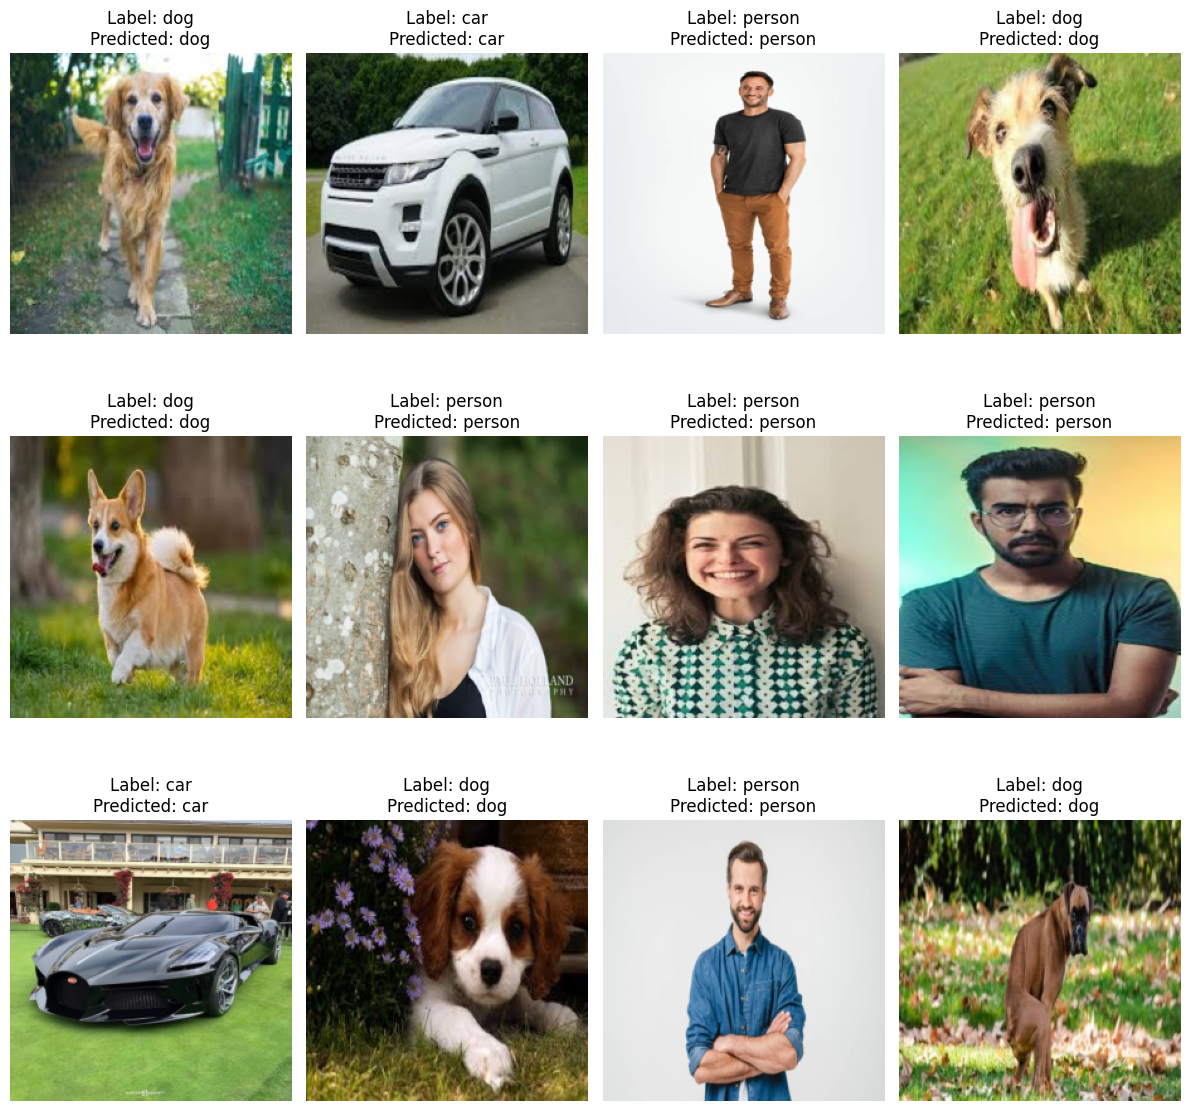

In [30]:
images_train, labels_train, predictions_train = get_predictions(model, train_loader)
num_images = min(12, len(images_train))
plot_predictions(images_train, labels_train, predictions_train, classes=class_list, num_images=num_images)

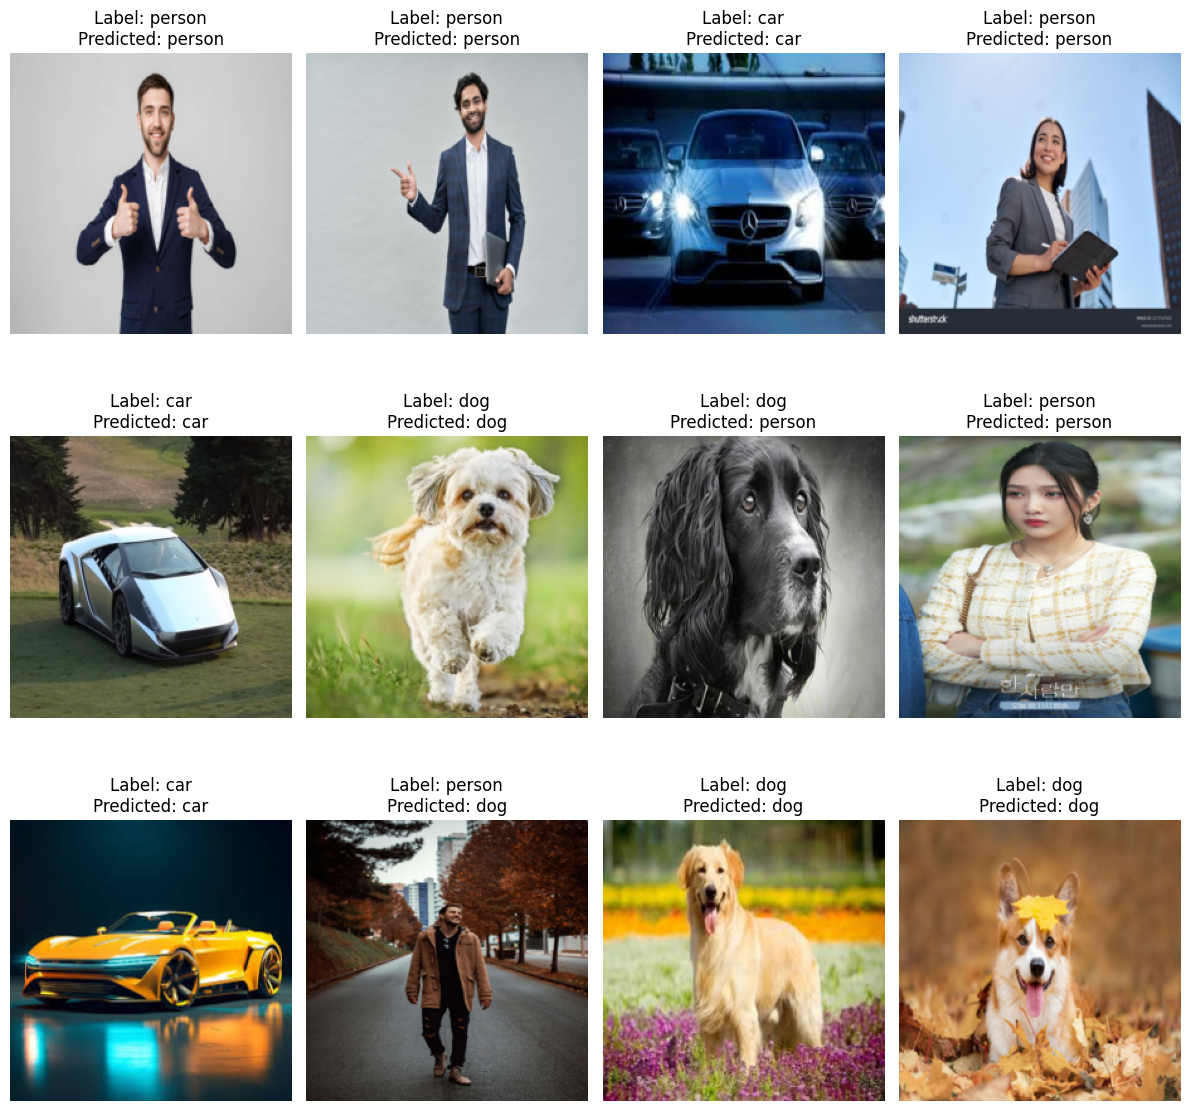

In [36]:
num_images = min(12, len(images_pred))
plot_predictions(images_pred, labels_pred, predictions_pred, classes=class_list, num_images=num_images)